In [5]:
# imports and configurations
import os
import warnings
from os import PathLike
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from matplotlib import colormaps
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation

from rich import print
from tqdm import tqdm

# import modules
from configurations import DEF_VAR_LIST, DEF_REM_COL_LIST, CSTYLE_FILE_STR
from grouped_bar_plot import grouped_bar_plot
from processing import load_mat_dir
from distributions import plot_clusters, create_protein_animation

In [6]:
# define the data directory
DATA_DIR = Path("data", "tests")

# configure the figure save directory
FIGURE_DIR = Path("figures", DATA_DIR.parts[-1])
os.makedirs(FIGURE_DIR, exist_ok=True)

# set plotting style
plt.style.use(["default", CSTYLE_FILE_STR])

# set the colormap
DEFAULT_COLORMAP = list(colormaps["tab10"].colors)

In [7]:
# get the data dictionary from the data directory
data_dict = load_mat_dir(DATA_DIR, DEF_VAR_LIST, DEF_REM_COL_LIST)

In [8]:
# add the final MT length to the sim_df
data_dict["sims"].keys()
length_vals = {}
for sim_name, sim_dict in data_dict["sims"].items():
    # extract the final length as the last entry in first col of mt_length
    length_vals[sim_name] = sim_dict["mt_length"][-1, 0]

# add the dictionary to the df
data_dict["df"]["final_length_units"] = data_dict["df"].index.map(length_vals)

# add final length column
data_dict["df"]["final_length"] = data_dict["df"]["final_length_units"]*data_dict["df"]["dx"]

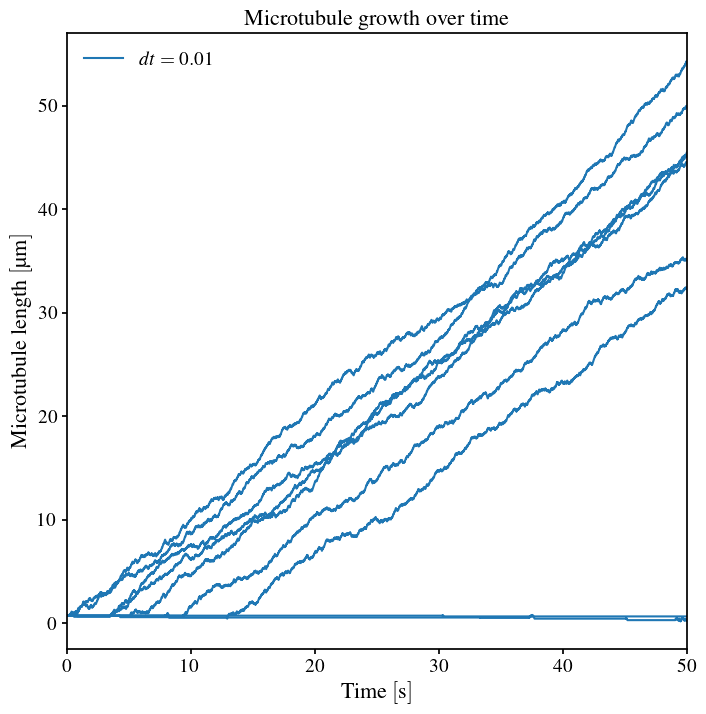

In [9]:
# plot the length of the mt over time
# define the figure
fig, ax = plt.subplots()

# define a dictionary to color similar tau_ratios
tau_ratio_dict = {}

# iterate over each simulation in sim_dict and get the time and length array
sim_names = list(data_dict["sims"].keys())
sim_names.sort(key=lambda x: data_dict["df"].loc[x]["tm_ratio"])
color_index = 0
for sim_name in sim_names:
    # get the arrays
    mt_length_array = data_dict["sims"][sim_name]["mt_length"]
    dx = data_dict["df"].loc[sim_name]["dx"]
    length_list = mt_length_array[:, 0] * dx

    # get the time information
    time_list = data_dict["sims"][sim_name]["time"]

    # get the tau binding rate T0 ratio
    dt = data_dict["df"].loc[sim_name]['dt']

    # define the label
    label = r"$dt=" + f"{dt}" + r"\ $"

    # get a unique color for each dt value
    # if the color has been used, make the label None
    if dt not in tau_ratio_dict.keys():
        tau_ratio_dict[dt] = DEFAULT_COLORMAP[color_index]
        color_index += 1
    else:
        label = None

    # plot the length over time for this mt
    ax.plot(
        time_list,
        length_list,
        label=label,
        color=tau_ratio_dict[dt]
    )

# set the axis limits
# the x limit should be the final time plus the second time
# this has the effect of showing an "even" value
ax.set_xlim(0, time_list[-1])

# set the labels
ax.set_xlabel(r"Time $\left[\qty{}{\second}\right]$")
ax.set_ylabel(r"Microtubule length $\left[\qty{}{\micro\meter}\right]$")
ax.set_title(r"Microtubule growth over time")

# add a legend
ax.legend()

# save the figure
fig.savefig(FIGURE_DIR / r"mt_growth_over_time")